In [14]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

from gensim.models import Doc2Vec
from gensim.models.doc2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%run utils.ipynb

# Lyrics2Vec CLASS

In [15]:
class Lyrics2Vec():
    
    def __init__(self, lyrics_df):

        self.lyrics_df = lyrics_df
        
        self.doc2vec_corpus = None
        self.model = None
            
    
    def create_doc2vec_corpus(self, tag, lyrics_df=None):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        print("Creating doc2vec tagged corpus ...", flush=True)
        tagged_corpus = []
        for row in tqdm(lyrics_df.iterrows()):
            if tag == 'genre':
                label = row[1].genre
            elif tag == 'index':
                label = row[0]
            else:
                raise AttributeError(f'Only "genre" or "index" ar valid tags. {tag} was given')
            text = row[1].lyrics
            tagged_corpus.append(TaggedDocument(text, tags=[label]))
        
        self.tagged_corpus = tagged_corpus
        return tagged_corpus
    
    
    def fit(self, tagged_corpus=None, vector_size=300, window=10, min_count=100, epochs=5000, dm=1, dbow_words=1):
        
        if tagged_corpus is None:
            tagged_corpus = self.doc2vec_corpus
        
        d2v_model = Doc2Vec(vector_size=vector_size, window=window, hs=0,
                            sample=0.000001, negative=5, min_count=min_count,
                            workers=-1, epochs=epochs, dm=dm, dbow_words=dbow_words
                           )
        d2v_model.build_vocab(tagged_corpus)
        d2v_model.train(tagged_corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
        
        self.model = d2v_model
        
        return
    
    @staticmethod
    def nearest_neighbors(query_vector, vectors, n=10):
        # compute cosine similarities
        ranks = np.dot(query_vector, vectors.T) / np.sqrt(np.sum(vectors
        **2, 1))
        # sort by similarity, reverse order, and get the top N
        neighbors = [idx for idx in ranks.argsort()[::-1]][:n]
        return neighbors
    
    
    def most_similar_to_genre(self, genres=None):
    
        if genres is None:
            genres = self.model.docvecs.doctags.keys()
    
        doc_words_most_similar = {}
        for tag in genres:
            doc_words_most_similar[tag] = self.nearest_neighbors(self.model.docvecs[tag], self.model.wv.vectors, n=10)
            tag_index = doc_words_most_similar[tag]
            tag_words = []
            index_to_word_mapping = {self.model.wv.vocab[word].index: word for word in self.model.wv.vocab.keys()}
            for index in tag_index:
                tag_words.append(index_to_word_mapping[index])
            doc_words_most_similar[tag] = tag_words

        return doc_words_most_similar
        
        
    def reduce_dimensionality(self, lyrics_vecs, method='tsne', n_components=3, pre_reduction_components=50):
        
        if method == 'tsne':
            
            # pre-reduce dimensionality to around 50 as advised by TSNE docs
            if not pre_reduction_components is None:
                print("Pre-reducing lyrics embeddings with PCA ...", flush=True)
                pca = PCA(n_components=pre_reduction_components)
                lyrics_vecs = pca.fit_transform(lyrics_vecs)
            
            print("Reducing lyrics embeddings with T-SNE ...", flush=True)
            tsne = TSNE(n_components=n_components)
            lyrics_vecs_reduced = tsne.fit_transform(lyrics_vecs)
                
        return lyrics_vecs_reduced
    
    
    def visualize_embeddings(self, lyrics_vecs_reduced, genres, title=None, dimensions=3):
        
        if title is None:
            title = ', '.join(genres)
        
        genres_idxs = self.lyrics_df.loc[self.lyrics_df.genre.isin(genres), :].index
        genres_labels = self.lyrics_df.loc[self.lyrics_df.genre.isin(genres), :].genre.to_numpy()
        genre_vectors = lyrics_vecs_reduced[genres_idxs]
        
        # from utils.ipynb
        plot_vectors(genre_vectors, title=title, labels=genres_labels, dimensions=3)

In [16]:
lyrics_df = pd.read_csv('/Users/lucamasserano/Desktop/BOCCONI/nlp/final_project/lyrics_project/data/lyrics_cleaned.csv')
lyrics_df.shape

(43844, 7)

In [19]:
with open('./data/trimmed_corpus.pickle', 'rb') as pickled_object:
    trimmed_corpus = pickle.load(pickled_object)

In [20]:
# put preprocessed corpus into dataframe
lyrics_df.loc[:, "lyrics"] = trimmed_corpus

In [25]:
lyrics_df.loc[9748:9758, :]

,artist,song,album,release_date,genre,lyrics,year
9748,Eagles,Do Something,Long Road Out Of Eden,NaN,Rock,"[walk, field, street, town, try, make, sense, ...",1985
9749,Eagles,King of Hollywood,The Long Run,1979-09-24,Rock,"[well, sit, there, leatherette, look, picture,...",1979
9750,Eagles,Midnight Flyer,On the Border,NaN,Rock,"[midnight, flyer, engineer, let, whistle, moan...",1982
9751,Eagles,Hollywood Waltz,One of These Nights,1975-06-10,Rock,"[acacia, bloom, southern, will, see, more, day...",1975
9752,Eagles,No More Cloudy Days,Long Road Out Of Eden,NaN,Rock,"[sit, foggy, window, staring, pour, rain, fall...",1979
9753,Eagles,It's Your World Now,Long Road Out Of Eden,NaN,Rock,"[perfect, day, sun, sink, low, evening, fall, ...",1980
9754,Eagles,My Man,On the Border,1974-03-24,Rock,"[tell, how, feel, like, roll, fast, spin, whee...",1974
9755,Eagles,Long Road Out Of Eden,Long Road Out Of Eden,NaN,Rock,"[moon, shine, palm, shadow, move, sand, whispe...",1973
9756,Eagles,Fast Company,Long Road Out Of Eden,2007-10-30,Rock,"[now, where, go, now, rush, listen, here, just...",2007
9757,Eagles,Somebody,Long Road Out Of Eden,NaN,Rock,"[feel, bad, bad, enough, know, come, play, rou...",1982


## Doc2Vec

#### Most "similar" words to each genre

In [21]:
genre2vec = Lyrics2Vec(lyrics_df=lyrics_df)

In [10]:
tagged_docs = genre2vec.create_doc2vec_corpus(tag='genre')

Creating doc2vec tagged corpus ...


43844it [00:08, 5384.32it/s]


In [11]:
genre2vec.fit(tagged_corpus=tagged_docs, vector_size=300)

In [22]:
with open('./genre2vec.pickle', 'rb') as pickled_object:
    genre2vec.model = pickle.load(pickled_object)

In [23]:
genre_to_most_similar = genre2vec.most_similar_to_genre()

In [24]:
genre_to_most_similar

{'Hip-Hop': ['ditch',
  'cradle',
  'lady',
  'leg',
  'keep',
  'childhood',
  'imma',
  'fine',
  'tank',
  'spider'],
 'Rock': ['should',
  'sweet',
  'trial',
  'witch',
  'roach',
  'transform',
  'relationship',
  'surely',
  'audience',
  'splash'],
 'Pop': ['woo',
  'connection',
  'judge',
  'dresser',
  'lip',
  'thread',
  'forbid',
  'elevate',
  'sanctuary',
  'island'],
 'Folk': ['lake',
  'rum',
  'declare',
  'excuse',
  'cloudy',
  'pic',
  'thirsty',
  'maiden',
  'park',
  'method'],
 'Electronic': ['artist',
  'stink',
  'lost',
  'cage',
  'mercy',
  'show',
  'spoon',
  'shady',
  'break',
  'sooner'],
 'Reggae': ['ayy',
  'pressure',
  'rate',
  'explode',
  'gutter',
  'joke',
  'lie',
  'wine',
  'real',
  'package'],
 'Other': ['cast',
  'nation',
  'defense',
  'fiend',
  'existence',
  'everyday',
  'creator',
  'salvation',
  'makeup',
  'hot'],
 'Metal': ['pure',
  'business',
  'careless',
  'shorty',
  'ignorance',
  'gucci',
  'log',
  'pink',
  'bowl',

In [ ]:
genre_to_most_similar

#### Find a clustering in lyrics2vector space

In [26]:
song2vec = Lyrics2Vec(lyrics_df=lyrics_df)

In [27]:
tagged_songs = song2vec.create_doc2vec_corpus(tag='index')

Creating doc2vec tagged corpus ...


43844it [00:07, 5848.18it/s]


In [28]:
song2vec.fit(tagged_corpus=tagged_songs)

In [29]:
lower_dim_vectors = song2vec.reduce_dimensionality(lyrics_vecs=song2vec.model.docvecs.vectors_docs, method='tsne', n_components=3)

Pre-reducing lyrics embeddings with PCA ...
Reducing lyrics embeddings with T-SNE ...


In [30]:
song2vec.visualize_embeddings(lyrics_vecs_reduced=lower_dim_vectors, genres=["Country", "Hip-Hop"], title="Country, Hip-Hop")

NameError: name 'song_vector_reduced' is not defined

In [120]:
genres = ["Hip-Hop", "Country"]
genres_idxs = song2vec.lyrics_df.loc[song2vec.lyrics_df.genre.isin(genres), :].index
genres_labels = song2vec.lyrics_df.loc[song2vec.lyrics_df.genre.isin(genres), :].genre.to_numpy()
genre_vectors = lower_dim_vectors[genres_idxs]

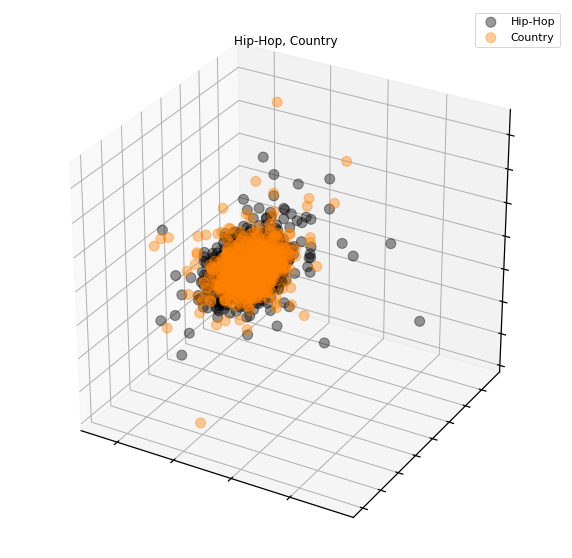

In [126]:
plot_vectors(genre_vectors, title=', '.join(genres), labels=genres_labels, dimensions=3, view_init=(30, 120))

# DENSE EMBEDDINGS

Whole corpus

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION

In [ ]:
with open('./data/lemmatized_corpus.pickle', "rb") as pickled_object:
    lemmatized_corpus = pickle.load(pickled_object)
lemmatized_corpus[4758]

In [ ]:
with open('./data/pos_lemmatized_corpus.pickle', "rb") as pickled_object:
    pos_lemmatized_corpus = pickle.load(pickled_object)
pos_lemmatized_corpus[4758]

In [ ]:
lyrics_df_lemmatized = lyrics_df.copy()
lyrics_df_lemmatized.loc[:, "lyrics"] = lemmatized_corpus

In [ ]:
lemmatized_corpus

In [ ]:
lyrics_df_pos_lemmatized = lyrics_df.copy()
lyrics_df_pos_lemmatized.loc[:, "lyrics"] = pos_lemmatized_corpus

In [ ]:
class Lyrics2Vec():
    
    def __init__(self, lyrics_df, genres=[], vector_size=300, window=10):
        
        self.genres = genres
        self.vector_size = vector_size
        self.window = window
        
        if len(genres) == 0:
            self.corpus = lyrics_df.loc[:, "lyrics"]
            self.model = Word2Vec(
                size=self.vector_size, window=self.window, hs=0, sample=0.000001, negative=5, min_count=100, workers=-1, iter=5000
            )
        else:
            self.corpus = {genre: lyrics_df.loc[lyrics_df.genre == genre, "lyrics"] for genre in genres}
            self.model = {genre: Word2Vec(
                size=self.vector_size, window=self.window, hs=0, sample=0.000001, negative=5, min_count=100, workers=-1, iter=5000
            ) for genre in genres}
    
    
    def fit(self, model=None, corpus=None):
        
        if model is None:
            model = self.model
        if corpus is None:
            corpus = self.corpus
        
        if isinstance(corpus, dict):
            for genre, genre_corpus in corpus.items():
                model[genre].build_vocab(genre_corpus)
                model[genre].train(genre_corpus, total_examples=model[genre].corpus_count, epochs=model[genre].epochs)
        else:
            model.build_vocab(corpus)
            model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)   

### Whole corpus

In [ ]:
lyrics2vec = Lyrics2Vec(lyrics_df_pos_lemmatized)

In [ ]:
lyrics2vec.fit()

In [ ]:
lyrics2vec.model.wv.most_similar("love", topn=10)

### By Genre

In [ ]:
lyrics2vec_genre = Lyrics2Vec(lyrics_df=lyrics_df_pos_lemmatized, genres=lyrics_df_pos_lemmatized.genre.unique())

In [ ]:
lyrics2vec_genre.vector_size

In [ ]:
lyrics2vec_genre.fit()

In [ ]:
lyrics2vec_genre.model["Hip-Hop"].wv.most_similar("love", topn=10)

In [ ]:
lyrics2vec_genre.model["Rock"].wv.most_similar("love", topn=10)

In [ ]:
lyrics2vec_genre.model["Pop"].wv.most_similar("love", topn=10)

In [ ]:
lyrics2vec_genre.model["Gospel"].wv.most_similar("love", topn=10)